In [1]:
# TODO: solve gamma map convergence to 0 active size
# hence, emd score is always 0

from bsi_zoo.config import get_leadfield_path
from bsi_zoo.data_generator import get_data

In [2]:
import numpy as np
import scipy.linalg as linalg
from mne.utils import logger, warn

def gamma_map(
    L,
    y,
    cov=1.0,
    alpha=0.2,
    max_iter=1000,
    tol=1e-15,
    update_mode=2,
    threshold=1e-5,
    gammas=None,
    n_orient=1,
):
    """Gamma_map method based on MNE package

    Parameters
    ----------
    L : array, shape (n_sensors, n_sources)
        lead field matrix modeling the forward operator or dictionary matrix
    y : array, shape (n_sensors,)
        measurement vector, capturing sensor measurements
    cov : float | array, shape (n_sensors, n_sensors)
        noise covariance matrix. If float it corresponds to the noise variance
        assumed to be diagonal.
    alpha : float
        Constant that makes a trade-off between the data fidelity and regularizer.
        Defaults to 0.2
    max_iter : int, optional
        The maximum number iterations. Defaults to 1000.
    tol : float
        Tolerance parameter for convergence.
    update_mode : int
        Update mode, 1: MacKay update, 2: Convex-bounding update (defaul),
        3: Expectation-Maximization update
    threshold : float
        A threshold paramter for forcing to zero the small values in
        reconstrcuted gamma in each iteration
    gammas : array, shape=(n_sources,)
        Initial values for posterior variances (gammas). If None, a
        variance of 1.0 is used.
    n_orient : int
        Number of consecutive sources which use the same gamma.

    Returns
    -------
    x : array, shape (n_sources,)
        Parameter vector, e.g., source vector in the context of BSI (x in the cost
        function formula).

    References
    ----------
    XXX
    """
    group_size = n_orient  # for compatibility with MNE implementation
    eps = np.finfo(float).eps
    n_sensors, n_sources = L.shape
    if y.ndim < 2:
        y = y[:, np.newaxis]
    n_times = y.shape[1]
    coef = np.zeros((n_sources, n_times))

    if isinstance(cov, float):
        cov = cov * np.eye(n_sensors)

    # alpha = mean(np.diag(cov)) accept alpha from params instead

    if gammas is None:
        gammas = np.ones(L.shape[1], dtype=np.float64)
        # L_square = np.sum(L ** 2,axis=0)
        # inv_L_square = np.zeros(n_sources)
        # L_nonzero_index = L_square > 0
        # inv_L_square[L_nonzero_index] = 1.0 / L_square[L_nonzero_index]
        # w_filter = spdiags(inv_L_square, 0, n_sources, n_sources) @ L.T
        # vec_init = mean(mean(w_filter @ y) ** 2)
        # gammas = vec_init * np.ones(L.shape[1])

    # # # apply normalization so the numerical values are sane
    # y_normalize_constant = np.linalg.norm(np.dot(y, y.T), ord='fro')
    # y /= np.sqrt(y_normalize_constant)
    # alpha /= y_normalize_constant
    # cov /= y_normalize_constant
    # L_normalize_constant = np.linalg.norm(L, ord=np.inf)
    # L /= L_normalize_constant

    # threshold = 0.2 * mean(np.diag(cov))
    threshold = eps
    
    if n_sources % group_size != 0:
        raise ValueError(
            "Number of sources has to be evenly dividable by the " "group size"
        )

    n_active = n_sources
    active_set = np.arange(n_sources)

    gammas_full_old = gammas.copy()
    # x_bar_old = coef

    if update_mode == 2:
        denom_fun = np.sqrt
    elif update_mode == 1:
        # do nothing
        def denom_fun(x):
            return x

    elif update_mode == 3:
        denom = None
    else:
        denom = None

    last_size = -1
    for iter_no in range(max_iter):
        gammas[np.isnan(gammas)] = 0.0
        gidx = np.abs(gammas) > threshold
        active_set = active_set[gidx]
        gammas = gammas[gidx]

        # update only active gammas (once set to zero it stays at zero)
        if n_active > len(active_set):
            n_active = active_set.size
            L = L[:, gidx]

        Sigma_y = np.dot(L * gammas[np.newaxis, :], L.T)
        Sigma_y.flat[:: n_sensors + 1] += alpha
        # Sigma_y += alpha * cov

        # Invert CM keeping symmetry
        U, S, _ = linalg.svd(Sigma_y, full_matrices=False)
        S = S[np.newaxis, :]
        del Sigma_y

        Sigma_y_inv = np.dot(U / (S + eps), U.T)
        Sigma_y_invL = np.dot(Sigma_y_inv, L)
        A = np.dot(Sigma_y_invL.T, y)  # mult. w. Diag(gamma) in gamma update

        if update_mode == 1:
            # MacKay fixed point update
            numer = gammas ** 2 * np.mean((A * A.conj()).real, axis=1)
            denom = gammas * np.sum(L * Sigma_y_invL, axis=0)
        elif update_mode == 2:
            # convex-bounding update
            numer = gammas * np.sqrt(np.mean((A * A.conj()).real, axis=1))
            denom = np.sum(L * Sigma_y_invL, axis=0)  # sqrt is applied below
        elif update_mode == 3:
            # Expectation Maximization (EM) update
            numer = gammas ** 2 * np.mean((A * A.conj()).real, axis=1) + gammas * (
                1 - gammas * np.sum(L * Sigma_y_invL, axis=0)
            )
        else:
            raise ValueError("Invalid value for update_mode")

        if group_size == 1:
            if denom is None:
                gammas = numer
            else:
                gammas = numer / np.maximum(denom_fun(denom), np.finfo("float").eps)
        else:
            numer_comb = np.sum(numer.reshape(-1, group_size), axis=1)
            if denom is None:
                gammas_comb = numer_comb
            else:
                denom_comb = np.sum(denom.reshape(-1, group_size), axis=1)
                gammas_comb = numer_comb / denom_fun(denom_comb)

            gammas = np.repeat(gammas_comb / group_size, group_size)

        # compute convergence criterion
        gammas_full = np.zeros(n_sources, dtype=np.float64)
        gammas_full[active_set] = gammas

        # compute the noise covariance
        err = np.sum(np.abs(gammas_full - gammas_full_old)) / np.sum(
            np.abs(gammas_full_old)
        )

        # err_x = linalg.norm(x_bar - x_bar_old, ord = 'fro')
        # print(err_x)

        gammas_full_old = gammas_full

        breaking = err < tol or n_active == 0
        if len(gammas) != last_size or breaking:
            logger.info(
                "Iteration: %d\t active set size: %d\t convergence: "
                "%0.3e" % (iter_no, len(gammas), err)
            )
            last_size = len(gammas)

        if breaking:
            break

    if iter_no < max_iter - 1:
        logger.info("\nConvergence reached !\n")
    else:
        warn("\nConvergence NOT reached !\n")

    # undo normalization and compute final posterior mean

    # n_const = np.sqrt(y_normalize_constant) / L_normalize_constant
    n_const = 1
    x_active = n_const * gammas[:, None] * A

    coef[active_set, :] = x_active
    if n_times == 1:
        # x = np.squeeze(coef,axis = 1)
        x = coef[:, 0]
    else:
        x = coef
    return x



In [3]:
# these are the SNR values we want to benchmark for:
# alpha_SNR = [0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01]

nnz = 3
orientation_type = 'fixed'
path_to_leadfield = get_leadfield_path(subject='CC120166', type=orientation_type)

# generate data
y, L, x, cov_scaled, noise_scaled = get_data(nnz=nnz,
                                        orientation_type=orientation_type,
                                        path_to_leadfield=path_to_leadfield,
                                        cov_type='full',
                                        alpha=0.9 # this is alpha SNR [0.99=40dB SNR]
                                )

<StemContainer object of 3 artists>

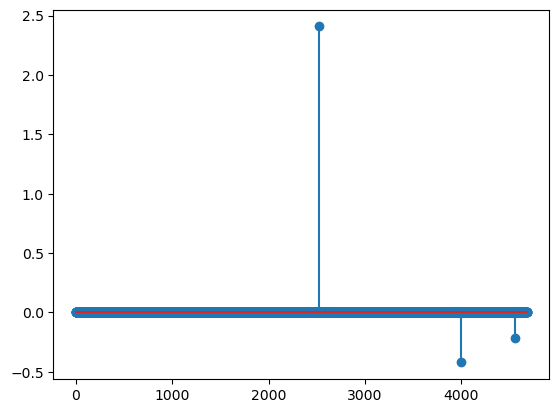

In [4]:
import matplotlib.pyplot as plt
plt.stem(x.sum(1))

In [5]:
# from mne.inverse_sparse._gamma_map import _gamma_map_opt

def _gamma_map_opt(
    M,
    G,
    alpha,
    maxit=10000,
    tol=1e-6,
    update_mode=1,
    group_size=1,
    gammas=None,
    verbose=None,
):
    """Hierarchical Bayes (Gamma-MAP).

    Parameters
    ----------
    M : array, shape=(n_sensors, n_times)
        Observation.
    G : array, shape=(n_sensors, n_sources)
        Forward operator.
    alpha : float
        Regularization parameter (noise variance).
    maxit : int
        Maximum number of iterations.
    tol : float
        Tolerance parameter for convergence.
    group_size : int
        Number of consecutive sources which use the same gamma.
    update_mode : int
        Update mode, 1: MacKay update (default), 3: Modified MacKay update.
    gammas : array, shape=(n_sources,)
        Initial values for posterior variances (gammas). If None, a
        variance of 1.0 is used.
    %(verbose)s

    Returns
    -------
    X : array, shape=(n_active, n_times)
        Estimated source time courses.
    active_set : array, shape=(n_active,)
        Indices of active sources.
    """
    from scipy import linalg

    G = G.copy()
    M = M.copy()

    if gammas is None:
        gammas = np.ones(G.shape[1], dtype=np.float64)

    eps = np.finfo(float).eps

    n_sources = G.shape[1]
    n_sensors, n_times = M.shape

    # apply normalization so the numerical values are sane
    M_normalize_constant = np.linalg.norm(np.dot(M, M.T), ord="fro")
    M /= np.sqrt(M_normalize_constant)
    alpha /= M_normalize_constant
    G_normalize_constant = np.linalg.norm(G, ord=np.inf)
    G /= G_normalize_constant

    if n_sources % group_size != 0:
        raise ValueError(
            "Number of sources has to be evenly dividable by the " "group size"
        )

    n_active = n_sources
    active_set = np.arange(n_sources)

    gammas_full_old = gammas.copy()

    if update_mode == 2:
        denom_fun = np.sqrt
    else:
        # do nothing
        def denom_fun(x):
            return x

    last_size = -1
    for itno in range(maxit):
        gammas[np.isnan(gammas)] = 0.0

        gidx = np.abs(gammas) > eps
        active_set = active_set[gidx]
        gammas = gammas[gidx]

        # update only active gammas (once set to zero it stays at zero)
        if n_active > len(active_set):
            n_active = active_set.size
            G = G[:, gidx]

        CM = np.dot(G * gammas[np.newaxis, :], G.T)
        CM.flat[:: n_sensors + 1] += alpha
        # Invert CM keeping symmetry
        U, S, _ = linalg.svd(CM, full_matrices=False)
        S = S[np.newaxis, :]
        del CM
        CMinv = np.dot(U / (S + eps), U.T)
        CMinvG = np.dot(CMinv, G)
        A = np.dot(CMinvG.T, M)  # mult. w. Diag(gamma) in gamma update

        if update_mode == 1:
            # MacKay fixed point update (10) in [1]
            numer = gammas**2 * np.mean((A * A.conj()).real, axis=1)
            denom = gammas * np.sum(G * CMinvG, axis=0)
        elif update_mode == 2:
            # modified MacKay fixed point update (11) in [1]
            numer = gammas * np.sqrt(np.mean((A * A.conj()).real, axis=1))
            denom = np.sum(G * CMinvG, axis=0)  # sqrt is applied below
        else:
            raise ValueError("Invalid value for update_mode")

        if group_size == 1:
            if denom is None:
                gammas = numer
            else:
                gammas = numer / np.maximum(denom_fun(denom), np.finfo("float").eps)
        else:
            numer_comb = np.sum(numer.reshape(-1, group_size), axis=1)
            if denom is None:
                gammas_comb = numer_comb
            else:
                denom_comb = np.sum(denom.reshape(-1, group_size), axis=1)
                gammas_comb = numer_comb / denom_fun(denom_comb)

            gammas = np.repeat(gammas_comb / group_size, group_size)

        # compute convergence criterion
        gammas_full = np.zeros(n_sources, dtype=np.float64)
        gammas_full[active_set] = gammas

        err = np.sum(np.abs(gammas_full - gammas_full_old)) / np.sum(
            np.abs(gammas_full_old)
        )

        gammas_full_old = gammas_full

        breaking = err < tol or n_active == 0
        if len(gammas) != last_size or breaking:
            logger.info(
                "Iteration: %d\t active set size: %d\t convergence: "
                "%0.3e" % (itno, len(gammas), err)
            )
            last_size = len(gammas)

        if breaking:
            break

    if itno < maxit - 1:
        logger.info("\nConvergence reached !\n")
    else:
        warn("\nConvergence NOT reached !\n")

    # undo normalization and compute final posterior mean
    n_const = np.sqrt(M_normalize_constant) / G_normalize_constant
    x_active = n_const * gammas[:, None] * A

    return x_active, active_set


def gamma_map_ok(
    y,
    L,
    cov=1.0,
    alpha=0.2,
    max_iter=1000,
    tol=1e-6,
    update_mode=2,
    # threshold=1e-5,
    gammas=None,
    n_orient=1,
    verbose=False,
):
    if isinstance(cov, float):
        cov = alpha * np.eye(L.shape[0])
    # Take care of whitening
    whitener = linalg.inv(linalg.sqrtm(cov))
    y = whitener @ y
    L = whitener @ L
    x_hat_, active_set = _gamma_map_opt(y, L, alpha=alpha, tol=tol,
                                        maxit=max_iter, gammas=gammas,
                                        update_mode=update_mode,
                                        group_size=n_orient,
                                        verbose=verbose)
    x_hat = np.zeros((L.shape[1], y.shape[1]))
    x_hat[active_set] = x_hat_
    return x_hat


In [6]:
# these are the alpha regularization values we currently benchmark for:
# estimator_alphas = np.logspace(0, -2, 20)[1:]
# array([0.78475997, 0.61584821, 0.48329302, 0.37926902, 0.29763514,
#        0.23357215, 0.18329807, 0.14384499, 0.11288379, 0.08858668,
#        0.06951928, 0.05455595, 0.04281332, 0.03359818, 0.02636651,
#        0.02069138, 0.01623777, 0.01274275, 0.01      ])

# x_hat = gamma_map(y, L, cov_scaled, alpha=1,  update_mode=2)
x_hat = gamma_map_ok(y, L, cov_scaled, alpha=0.8, update_mode=2, verbose=True)

In [7]:
x_hat.shape, L.shape, y.shape

((4686, 10), (204, 4686), (204, 10))

<StemContainer object of 3 artists>

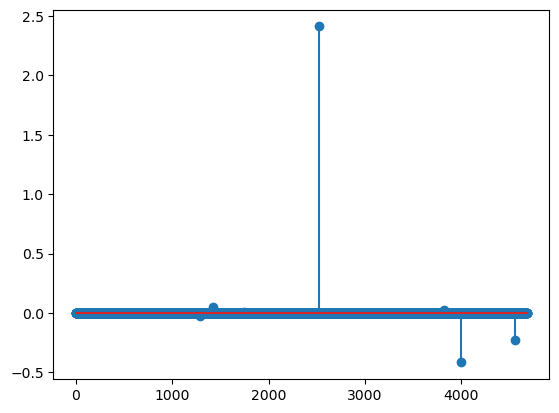

In [8]:
import matplotlib.pyplot as plt
plt.stem(x_hat.sum(1))

In [9]:
from bsi_zoo.metrics import emd

print('EMD:', emd(x, x_hat, subject='CC120166', orientation_type=orientation_type, nnz=nnz, y=y, L=L, cov=cov_scaled))

EMD: 0.0011597644699647782
